In [2]:
import numpy as np
import pandas as pd
from scipy import linalg
from matplotlib import pyplot as plt
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1

# Boston Dataset

In [80]:
def get_fresh_boston_data(keep_locations=False):
    weird_dtypes = {
        s: 'object' for s in [
            'INCIDENT_NUMBER',
            'OFFENSE_CODE_GROUP',
            'OFFENSE_DESCRIPTION',
            'DISTRICT',
            'REPORTING_AREA',
            'SHOOTING',
            'OCCURRED_ON_DATE',
            'DAY_OF_WEEK',
            'UCR_PART',
            'STREET'
        ]
    }
    df = pd.read_csv("boston_crime.csv",encoding = "ISO-8859-1",dtype=weird_dtypes)
    df.rename({name : name.lower() for name in df.columns}, axis=1, inplace=True)
    df["shooting"] = df["shooting"] == 'Y'
    
    
    ############# nominal / ordinal encoding #############
    
    
    # ucr_part is nominal (part I is the most extreme)
    # We use one-hot encoding similar to that done on the prelim;
    # 'ucr_lte_two' indicates that it was in part 2 or less severe
    # (note that part 3 is less severe than part 2)
    
    df["ucr_part"].fillna("Other",inplace=True) # we assume that most NaN are the same as "Other"
    
    def real_encode_ucr(s):
        num = s.rsplit(" ", 1)[-1]
        if num == "One":
            return 1
        if num == "Two":
            return 2
        if num == "Three":
            return 3
        if num == "Other":
            return 4 
            # We want "Other" and NaN to be represented as "no information".
            # We encode it as 4 (less severe than the least severe code), so 
            # that it will be encoded as "1" in all three features we generate below.
            # We hope that this will provide the least biased information.
    
    real_encoded_ucr_part = df["ucr_part"].apply(real_encode_ucr)
    
    df["ucr_lt_1"] = real_encoded_ucr_part > 1 # "lte" stands for "severity less than or equal to"
    df["ucr_lt_2"] = real_encoded_ucr_part > 2
    df["ucr_lt_3"] = real_encoded_ucr_part > 3 
    # note that 4 is a fake part that we made up to deal with missing data
    
    df["is_weekend"] = df["day_of_week"].apply(lambda s: s == "Saturday" or s == "Sunday")
    
    if keep_locations:
        return df
    
    
    ################## do processing in order to be blind to neighborhood location #############
    df.drop(labels=["incident_number"], axis=1, inplace=True)
    
    # drop latitude and longitude
    df.drop(labels=["lat","long","location","district","reporting_area"], axis=1, inplace=True)
    
    # reporting_area
    df["street_type"] = df["street"].apply(lambda s: "" if not isinstance(s,str) else s.rsplit(" ", 1)[-1])
    street_counts = df["street_type"].value_counts()
    def replace_streets(streetpostfix):
        common_street_names = [
            'BROADWAY','TER',''
            
        ]
        if (street_counts[streetpostfix] < 350 or streetpostfix in common_street_names):
            return "OTHER"
        return streetpostfix
    df["street_type"] = df["street_type"].apply(replace_streets)
    df.drop(labels=["street"], axis=1, inplace=True)
    
    
    return df

In [4]:
df = get_fresh_boston_data()

In [5]:
df.head()

,offense_code,offense_code_group,offense_description,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,ucr_lte_two,ucr_lte_three,ucr_lte_four,is_weekend,street_type
0,2403,Disorderly Conduct,DISTURBING THE PEACE,False,2018-10-03 20:13:00,2018,10,Wednesday,20,Part Two,True,False,False,False,ST
1,3201,Property Lost,PROPERTY - LOST,False,2018-08-30 20:00:00,2018,8,Thursday,20,Part Three,True,True,False,False,ST
2,2647,Other,THREATS TO DO BODILY HARM,False,2018-10-03 19:20:00,2018,10,Wednesday,19,Part Two,True,False,False,False,ST
3,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,False,2018-10-03 20:00:00,2018,10,Wednesday,20,Part One,False,False,False,False,ST
4,3122,Aircraft,AIRCRAFT INCIDENTS,False,2018-10-03 20:49:00,2018,10,Wednesday,20,Part Three,True,True,False,False,ST


First, let's do a naive analysis of the distribution of several features, to see what kind of biases might arise from data availability.

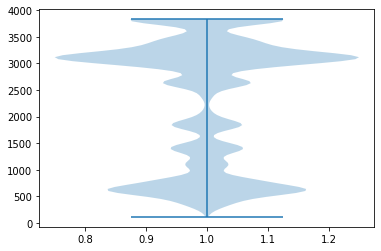

In [6]:
plt.violinplot(df["offense_code"])
plt.show()

In [7]:
print(np.var([np.unique(df["offense_code"], return_counts=True)[1]]))

10577228.015015014


It appears that there is a large variance in the number of occurences of offense codes. Therefore, a regression or classification on offense code using the full dataset is very likely to be biased towards accurately predicting frequent offense codes are not the less frequent offense codes. This is good if we are trying to accurately predict the majority of points, and weight all offense codes equally. However, this could grealty skew our results if we are trying to give higher weight to more extreme crimes, which are likely to happen less than less extreme crimes.
Since we have very little data on some crimes, simply cutting down the number of data points trained on from each offense code would either result in too little data (if we limited the number of daa points from each offense code to the lowest frequency of any their offense code) or simply not work (if we probabilistically choose points based on the frequency of their offense code).

Instead, it might be better to use offense_code_group, which nicely bins the offenses for us.

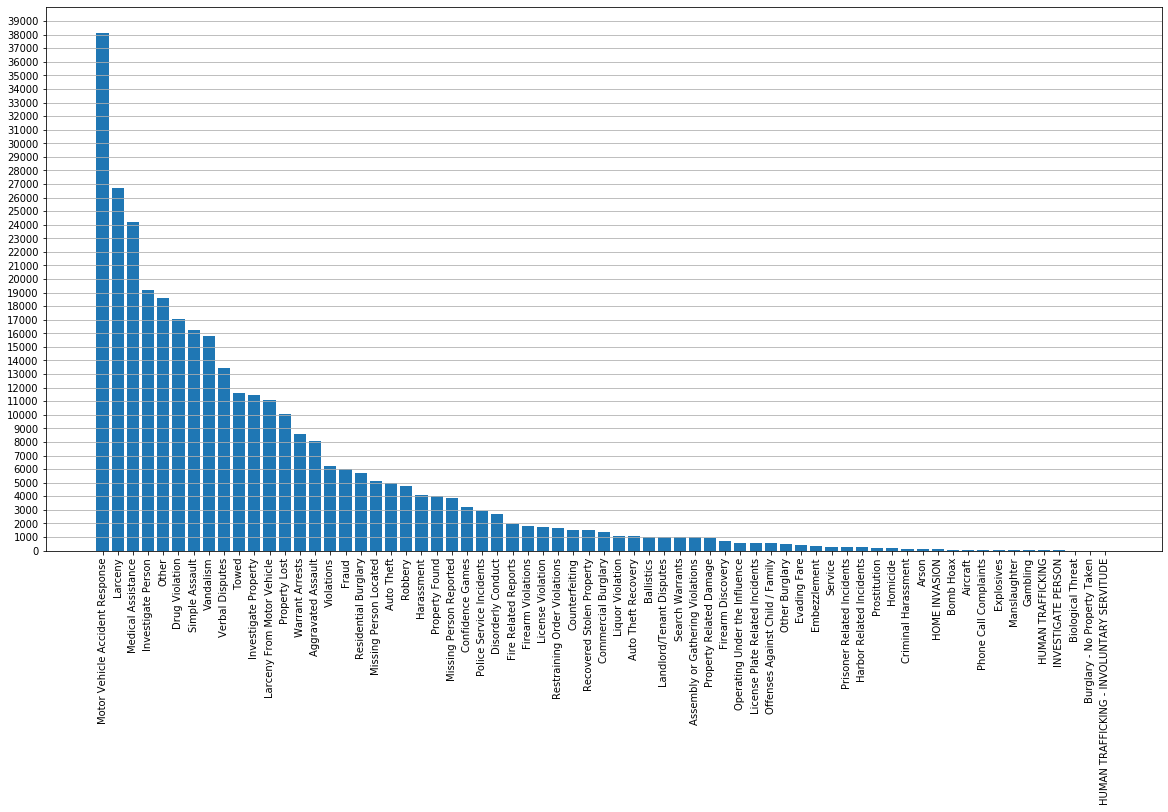

In [8]:
group, group_counts = np.unique(df["offense_code_group"], return_counts=True)
order = np.argsort(group_counts)[::-1]
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(group[order], height=group_counts[order])
plt.xticks(rotation='vertical')
plt.yticks(range(0,group_counts[order[0]]+1000,1000))
plt.grid(True, which='major', axis='y')
plt.show()

Here, we can see that there are at least around 1000 data points for the majority of code groups. We should ignore the other code groups, because we do not have enough data to accurately predict them. This is a shame, because these include many extreme crimes of particular interest, but it is better to narrow the scope of our model than to extrapolate without good reason to believe that we can accurately extrapolate.

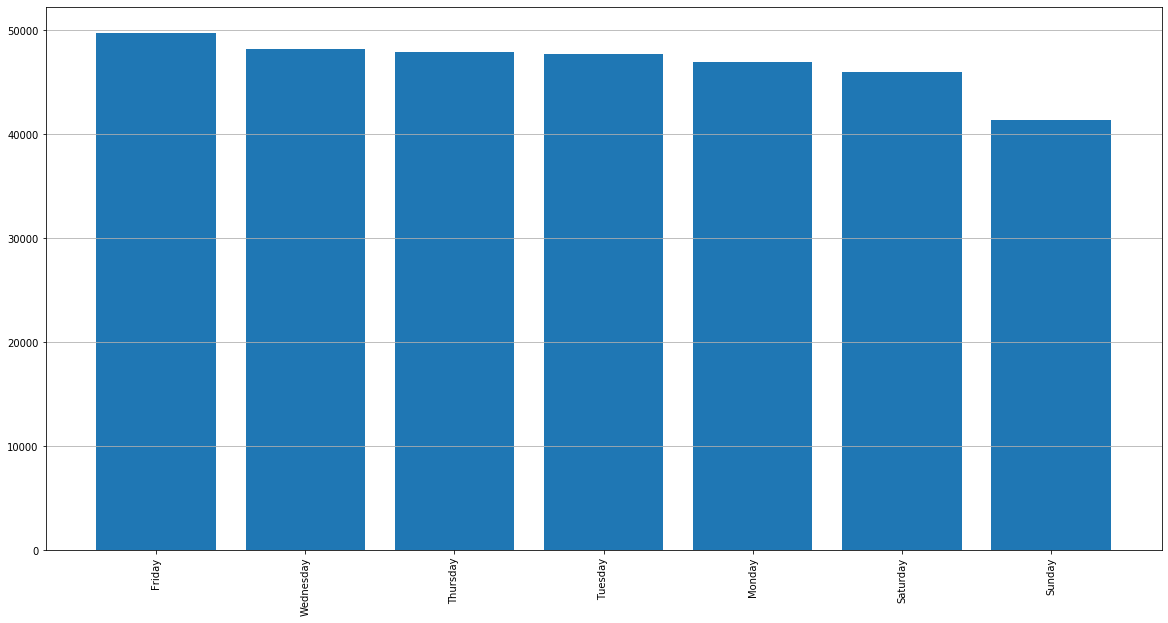

In [9]:
group, group_counts = np.unique(df["day_of_week"], return_counts=True)
order = np.argsort(group_counts)[::-1]
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(group[order], height=group_counts[order])
plt.xticks(rotation='vertical')
plt.yticks(range(0,group_counts[order[0]]+1000,10000))
plt.grid(True, which='major', axis='y')
plt.show()

It seems like we have a similar number of data points from each day of the week.

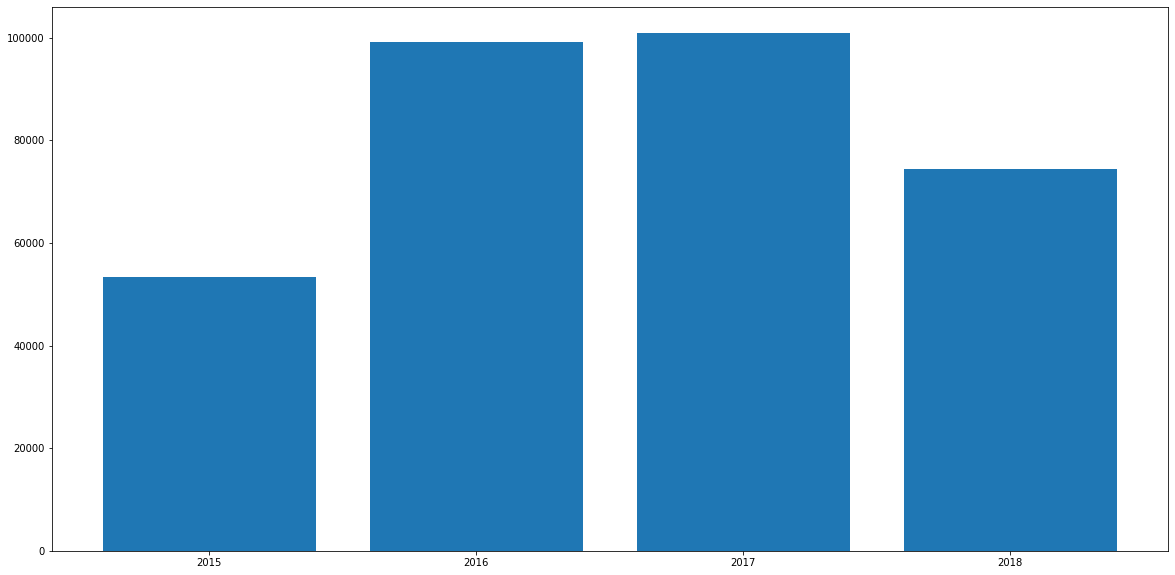

In [10]:
plt.bar(*np.unique(df["year"], return_counts=True))
plt.xticks(range(min(df["year"]),max(df["year"])+1))
plt.show()

We have significantly less data from 2015 compared to the other years. At this time, we don't believe this would cause any issues, since we still have a good amount of data from 2015 and we don't expect the distribution of times that crimes happen to change much throughout four years.
Let's quickly check this by looking at the summary statistics throughout the different years:

In [11]:
def print_summary_stats(xs,indent=0):
    init_tabs = " "*indent
    print(init_tabs+"mean:\t", np.mean(xs))
    print(init_tabs+"median:\t", np.median(xs))
    print(init_tabs+"mode:\t", np.unique(xs)[-1])
    print(init_tabs+"sd:\t", np.std(xs))
    print(init_tabs+"min:\t", np.min(xs))
    print(init_tabs+"max:\t", np.max(xs))
    print(init_tabs+"count:\t", len(xs))
    print(init_tabs+"missing:", sum(np.isnan(xs)))
    
    print(init_tabs+"Percentiles:")
    for p in [10,25,50,75,90]:
        print(init_tabs+"\t",str(p) + "%:", np.percentile(xs,p))

In [12]:
for year in sorted(np.unique(df["year"])):
    print("Summary stats for 'hour' in year "+str(year)+":")
    print_summary_stats(df[df["year"] == year]["hour"],6)

Summary stats for 'hour' in year 2015:
      mean:	 13.02535960443512
      median:	 14.0
      mode:	 23
      sd:	 6.366802877918359
      min:	 0
      max:	 23
      count:	 53392
      missing: 0
      Percentiles:
      	 10%: 2.0
      	 25%: 9.0
      	 50%: 14.0
      	 75%: 18.0
      	 90%: 21.0
Summary stats for 'hour' in year 2016:
      mean:	 13.160651239736115
      median:	 14.0
      mode:	 23
      sd:	 6.2899566827179125
      min:	 0
      max:	 23
      count:	 99134
      missing: 0
      Percentiles:
      	 10%: 3.0
      	 25%: 9.0
      	 50%: 14.0
      	 75%: 18.0
      	 90%: 21.0
Summary stats for 'hour' in year 2017:
      mean:	 13.141601775347242
      median:	 14.0
      mode:	 23
      sd:	 6.277429524825562
      min:	 0
      max:	 23
      count:	 100938
      missing: 0
      Percentiles:
      	 10%: 3.0
      	 25%: 9.0
      	 50%: 14.0
      	 75%: 18.0
      	 90%: 21.0
Summary stats for 'hour' in year 2018:
      mean:	 13.081688095110012
 

In [13]:
for year in sorted(np.unique(df["year"])):
    print("Summary stats for 'month' in year "+str(year)+":")
    print_summary_stats(df[df["year"] == year]["month"],6)

Summary stats for 'month' in year 2015:
      mean:	 9.19383053640995
      median:	 9.0
      mode:	 12
      sd:	 1.8807488423559056
      min:	 6
      max:	 12
      count:	 53392
      missing: 0
      Percentiles:
      	 10%: 7.0
      	 25%: 8.0
      	 50%: 9.0
      	 75%: 11.0
      	 90%: 12.0
Summary stats for 'month' in year 2016:
      mean:	 6.5643068977343795
      median:	 7.0
      mode:	 12
      sd:	 3.3894966394370845
      min:	 1
      max:	 12
      count:	 99134
      missing: 0
      Percentiles:
      	 10%: 2.0
      	 25%: 4.0
      	 50%: 7.0
      	 75%: 9.0
      	 90%: 11.0
Summary stats for 'month' in year 2017:
      mean:	 6.552111196972399
      median:	 7.0
      mode:	 12
      sd:	 3.3612805255616633
      min:	 1
      max:	 12
      count:	 100938
      missing: 0
      Percentiles:
      	 10%: 2.0
      	 25%: 4.0
      	 50%: 7.0
      	 75%: 9.0
      	 90%: 11.0
Summary stats for 'month' in year 2018:
      mean:	 5.168446393028135
      

It seems that the hours at which crime tend to occur are similar throughout all the years (although summary statistics can be deceiving), but the months during which crimes occur vary more significantly. When creating models, we will need to investigate this discrepancy more differently.

Now, let's create a quick linear model on the Boston Dataset, to try to predict which days shootings occur.

In [46]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#model = SVC()
model = DecisionTreeClassifier()

def sample_shooting_data(train_percentage=None,test_percentage=0.2):
    if train_percentage == None:
        train_percentage = 1 - test_percentage
    train_size = len(df.index) * train_percentage
#     train = set(range(len(df.index)))
    train = set()
    test = set()
    shootings_list = [i for i in range(len(df.index)) if df.loc[i,"shooting"] == True]
    shootings = set(shootings_list)
    nonshootings = set(i for i in range(len(df.index)) if i not in shootings)
    
    num_shootings = len(shootings)
    num_nonshootings = len(nonshootings)
    
    for i in np.random.choice(list(shootings), int(train_percentage * num_shootings), replace=False):
        train.add(i)
    for i in np.random.choice(list(nonshootings), int(train_percentage * num_nonshootings), replace=False):
        train.add(i)
    
    for i in train:
        if i in shootings:
            shootings.remove(i)
        else:
            nonshootings.remove(i)
    for i in np.random.choice(list(shootings), int(test_percentage * num_shootings), replace=False):
        test.add(i)
    for i in np.random.choice(list(nonshootings), int(test_percentage * num_nonshootings), replace=False):
        test.add(i)
    
#     for i in np.random.choice(shootings, int(test_percentage * len(shootings)), replace=False):
#         train.remove(i)
#         test.add(i)
#     for i in np.random.choice(nonshootings, int(test_percentage * len(nonshootings)), replace=False):
#         train.remove(i)
#         test.add(i)
    return list(train), list(test)

In [47]:
print(len(train))
print(len(test))

163909
32781


In [48]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [49]:
df.columns

Index(['offense_code', 'offense_code_group', 'offense_description', 'shooting',
       'occurred_on_date', 'year', 'month', 'day_of_week', 'hour', 'ucr_part',
       'ucr_lte_two', 'ucr_lte_three', 'ucr_lte_four', 'is_weekend',
       'street_type'],
      dtype='object')

In [75]:
from sklearn.metrics import confusion_matrix

features = ['year', 'month', 'day_of_week', 'hour','street_type']
X = pd.get_dummies(df[features])
y = df["shooting"]

train_accuracies = []
test_accuracies = []
generalization_error = []
for _ in range(20):
    train,test = sample_shooting_data(0.5,0.5)
    model.fit(X.iloc[train], y.iloc[train])
    
    _, _, false_negative, true_positive = confusion_matrix(y.iloc[train], model.predict(X.iloc[train])).ravel()
    train_accuracies.append(true_positive /(false_negative + true_positive))
    
    _, _, false_negative, true_positive = confusion_matrix(y.iloc[test], model.predict(X.iloc[test])).ravel()
    test_accuracies.append(true_positive /(false_negative + true_positive))
    
    generalization_error.append(train_accuracies[-1] - test_accuracies[-1])
    
    # print(str(true_positive) +"/("+str(false_negative) + "+" + str(true_positive) +")")

In [76]:
print("train accuracy:")
print_summary_stats(train_accuracies,6)

train accuracy:
      mean:	 0.11347248576850096
      median:	 0.1110056925996205
      mode:	 0.12903225806451613
      sd:	 0.010643114734254389
      min:	 0.09867172675521822
      max:	 0.12903225806451613
      count:	 20
      missing: 0
      Percentiles:
      	 10%: 0.10037950664136623
      	 25%: 0.10436432637571158
      	 50%: 0.1110056925996205
      	 75%: 0.12381404174573055
      	 90%: 0.127134724857685


In [77]:
print("test accuracy:")
print_summary_stats(test_accuracies,6)

test accuracy:
      mean:	 0.04516129032258065
      median:	 0.04554079696394687
      mode:	 0.06072106261859583
      sd:	 0.008240626470819152
      min:	 0.026565464895635674
      max:	 0.06072106261859583
      count:	 20
      missing: 0
      Percentiles:
      	 10%: 0.03757115749525616
      	 25%: 0.039373814041745725
      	 50%: 0.04554079696394687
      	 75%: 0.051233396584440226
      	 90%: 0.053889943074003806


In [78]:
print("generalization error (measured by difference in train and test accuracy):")
print_summary_stats(generalization_error,6)

generalization error (measured by difference in train and test accuracy):
      mean:	 0.06831119544592029
      median:	 0.07115749525616698
      mode:	 0.09297912713472486
      sd:	 0.013709595345873581
      min:	 0.043643263757115754
      max:	 0.09297912713472486
      count:	 20
      missing: 0
      Percentiles:
      	 10%: 0.04933586337760911
      	 25%: 0.05834914611005693
      	 50%: 0.07115749525616698
      	 75%: 0.07637571157495256
      	 90%: 0.08576850094876662


In [79]:
df.corr()["shooting"]

offense_code    -0.058043
shooting         1.000000
year            -0.000299
month            0.007760
hour             0.004458
ucr_lte_two     -0.065181
ucr_lte_three   -0.037246
ucr_lte_four     0.001303
is_weekend       0.014121
Name: shooting, dtype: float64

# Chicago Dataset

In [ ]:
chicago_bq_client = None
has_fetched_chicago = False
def get_fresh_chicago_data(max_rows=10000, force_new_fetch=True):
    if force_new_fetch or not has_fetched_chicago:
        chicago_bq_client = bigquery.Client(project='bigquery-public-data')
        
    chicago_db = chicago_bq_client.get_table(
        chicago_bq_client.get_dataset(
            chicago_bq_client.dataset("chicago_crime", project="bigquery-public-data")
        ).table('crime')
    )
    df = chicago_bq_client.list_rows(chicago_db,max_results=max_rows).to_dataframe()
    if force_new_fetch or not has_fetched_chicago:
        
        # drop useless columns
        df.drop(labels=['unique_key','case_number'], axis=1, inplace=True)
        
        # iucr is just a code for primary_type. We keep primary_type instead of iucr
        # because it is more interpretable.
        df.drop(labels=['iucr'], axis=1, inplace=True)
        
        # drop location data
        df.drop(labels=[
            'x_coordinate',
            'y_coordinate',
            'updated_on',
            'latitude',
            'longitude',
            'location',
            'district',
            'ward',
            'community_area',
            'beat'
        ], axis = 1, inplace = True)

        df["block"] = df["block"].apply(lambda s: "" if not isinstance(s,str) else s.rsplit(" ", 1)[-1])
        block_postfix_counts = df["block"].value_counts()
        def replace_blocks(blockpostfix):
            common_street_names = [
                'BROADWAY','TER',''
            ]
            if (block_postfix_counts[blockpostfix] < 350 or blockpostfix in common_street_names):
                return "OTHER"
            return blockpostfix
        df["block"] = df["block"].apply(replace_blocks)
        
    has_fetched_chicago = True
    return df

In [ ]:
df = get_fresh_chicago_data()

In [ ]:
df.head()

# SF Dataset

In [8]:
sf_bq_client = bigquery.Client(project='bigquery-public-data')
sf_db = sf_bq_client.get_dataset(
            sf_bq_client.dataset("san_francisco", project="bigquery-public-data")
)

In [9]:
for table in sf_bq_client.list_tables(sf_db):
    print("\n")
    print(table.table_id)
    print(list(sf_bq_client.list_rows(table,max_results=100).to_dataframe().columns))



311_service_requests
['unique_key', 'created_date', 'closed_date', 'resolution_action_updated_date', 'status', 'status_notes', 'agency_name', 'category', 'complaint_type', 'descriptor', 'incident_address', 'supervisor_district', 'neighborhood', 'location', 'source', 'media_url', 'latitude', 'longitude', 'police_district']


bikeshare_stations
['station_id', 'name', 'latitude', 'longitude', 'dockcount', 'landmark', 'installation_date']


bikeshare_status
['station_id', 'bikes_available', 'docks_available', 'time']


bikeshare_trips
['trip_id', 'duration_sec', 'start_date', 'start_station_name', 'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 'bike_number', 'zip_code', 'subscriber_type']


film_locations
['title', 'release_year', 'locations', 'fun_facts', 'production_company', 'distributor', 'director', 'writer', 'actor_1', 'actor_2', 'actor_3']


sffd_service_calls
['call_number', 'unit_id', 'incident_number', 'call_type', 'call_date', 'watch_date', 'received_tim